<a href="https://colab.research.google.com/github/mannixp/CHIST/blob/main/PDF_Construction_1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get update --fix-missing
try:
    import firedrake
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/firedrake-install-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
    import firedrake

Given a numerical approximation of a random field or random function $Y(\boldsymbol{x})$ over an arbitrary domain $\boldsymbol{x} \in \Omega$ (which can be thought of as a multidimensional space $\mathbb{R}^n$), we want to calculate its corresponding cumulative density function (CDF) $F(y)$ and probability density function (PDF) $f(y)$ such that these functions are continuous and make the best possible use of the available data. The CDF of $Y(\boldsymbol{x})$ is given by
\begin{equation*}
    F(y) = \int_{\Omega} \mathbb{I}(y,\boldsymbol{x}) d \boldsymbol{x},
\end{equation*}
its PDF by $f(y) = \partial_y F(y)$ and the indicator function is given by
\begin{equation*}
    \mathbb{I}(y,\boldsymbol{x}) =
    \begin{cases}
    1 \quad &: Y(\boldsymbol{x}) < y, \\
    0 \quad &: \text{otherwise}.
    \end{cases}
\end{equation*}
While seemingly simple the integral of the indicator function is in practice difficult to calculate numerically and the common approach is to jump from the analytical form of $F(y)$ directly to its piecewise constant approximation.

A typical approach to approximating the CDF is to regard $Y(\boldsymbol{x}_i) = (Y_1, Y_2, \cdots ,Y_n)$ as a uniformly sampled vector of $n$ discrete points, and to calculate its discrete approximation either as
\begin{equation*}
    \hat{F}(y) = \frac{1}{n} \sum_{i=1}^n \mathbb{1}_{Y_i \leq y}
\end{equation*}
which jumps up by $1/n$ at each data point and thus lets the data discretise the codomain $\Omega_{Y}$, or to impose a discretisation of $m$ bins $y_0 < y_1 < \cdots < y_m$ and obtain the approximation
\begin{equation*}
    \hat{F}(y_m) = \frac{1}{n} \sum_{i=1}^n \mathbb{1}_{Y_i \leq y_m}
\end{equation*}
which jumps up between bins by $\hat{F}(y_2) - \hat{F}(y_1) \neq 1/m$ and takes a constant value within each bin. While this gaurantees a monotonic CDF it is clearly discontinuous and has not made the best use of our data as shown in the example below.

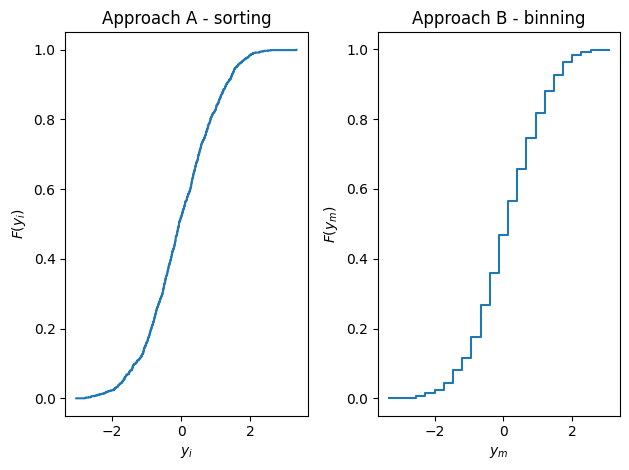

In [3]:
import numpy as np
import matplotlib.pyplot as plt


n = 10**3 # Number of data points
Y = np.random.randn(n) # Y(x,z) = Y_{i,j} flattend

fig = plt.figure()

# Approach (A)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
y = np.sort(Y)
F = 1.* np.arange(len(Y))/(len(Y)-1);

ax1 = fig.add_subplot(121)
ax1.set_title('Approach A - sorting')
ax1.plot(y,F, drawstyle='steps-post')
ax1.set_xlabel(r'$y_i$')
ax1.set_ylabel(r'$F(y_i)$')
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# Approach (B)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
m  = 25 # Number of bins
dy = (2*max(Y))/m;
I  = lambda Y,y_m: [1 if Y_i <= y_m else 0 for Y_i in Y];
y  = np.arange(-max(Y),max(Y),dy);
F  = [ np.mean(I(Y,y_m)) for y_m in y ];

ax2 = fig.add_subplot(122)
ax2.set_title('Approach B - binning')
ax2.plot(y,F, drawstyle='steps-post')
ax2.set_xlabel(r'$y_m$')
ax2.set_ylabel(r'$F(y_m)$')
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

plt.tight_layout()
plt.show()

In the example above we have (1) implicitly assumed a basis of piecewise constant functions and (2) regarded the random field not as a continuous function of space but instead as a vector of grid point evaluations. How do we refine this approach?

To address the first point we can define an appropriate function space
\begin{equation*}
    F \in V_F \subset L^2(\Omega_Y), \quad \text{where} \quad F: \Omega_Y \to [0,1] \quad \text{s.t.} \; \int F^2 dy < \infty,
\end{equation*}
followed by a set of basis functions $\{\phi_i(y)\} \in V_F$ such that
\begin{equation*}
    F(y) = \sum_i f_i \phi_i(y).
\end{equation*}
By choosing the space of square integrable functions we ensure that $F$ is monotonic. While this does not garauntee continuity we will see that this is not strictly necessary if we only require $f(y)$ to be continuous. Formulated in this manner we can modify the definition of $V_F$ as required.


To address the second point we now consider the projection of $F(y)$ into $V_F$ as defined by
\begin{equation*}
    \int_{\Omega_Y \times \Omega} \hat{F} v \; dy d \boldsymbol{x} = \int_{\Omega_Y \times \Omega} \mathbb{I}(y,\boldsymbol{x}) v \; dy d \boldsymbol{x}, \quad \text{where} \quad \forall \; v \in V,
\end{equation*}
where $\hat{F} \in \hat{V}_F$ denotes the extension of $F \in V_F$ into $\Omega$. Substituting in for $\hat{F}$ and considering the projection component-wise we obtain
\begin{equation*}
    \sum_{i,j} \left[ \int_{\Omega_Y \times \Omega} \hat{\phi}_i \hat{\phi}_j \; dy d \boldsymbol{x} \right] f_j = \sum_i \left[ \int_{\Omega_Y \times \Omega} \mathbb{I}(y,\boldsymbol{x}) \hat{\phi}_i(y,\boldsymbol{x}) \; dy d \boldsymbol{x} \right],
\end{equation*}
where the left hand side denotes the bilinear form and the right hand side the linear form. The precise statement of these function spaces is
\begin{equation}
    \hat{V}_F = V_F \times I \times I, \quad \hat{V}_I = V_F \times V \times V,
\end{equation}
where $V$ denotes the space of piecewise constant functions, as is appropriate when representing the indicator function. To create these function spaces implement the projection operations we will make use of the finite element code Firedrake.

In [5]:
from firedrake import *
mesh = IntervalMesh(15,0,1)       # Construct a mesh using 10 elements
V_F  = FunctionSpace(mesh,"DG",1) # Define a function space consisting of piecewise constant functions

u = TrialFunction(V_F)
v = TestFunction(V_F)

We then declare our CDF over our function space and assign it the value of our right hand side. This will be the indicator function acting on the random function $Y(\boldsymbol{x})$

In [6]:
y = SpatialCoordinate(mesh)
#I = Function(V_F).interpolate( y[0] )
mu    = 0.5
sigma = 1e-01
I =  Function(V_F).interpolate(.5*(1 + erf((y[0]-mu)/(sigma*sqrt(2)))) ) # When can we use interpolation versus projection ?
#I = project( .5*(1 + erf((y[0]-mu)/(sigma*sqrt(2)))), V_F)

We declare the bilinear and linear forms for the left and right hand sides of our equation and then we solve the equation, by defining $F$ to be a function holding the solution and then passing this along with $a$ and $L$ to a solver.

In [7]:
a = inner(u,v) * dx
L = inner(I,v) * dx


F = Function(V_F)
solve(a == L, F, solver_parameters={'ksp_type':'cg','pc_type':'none'})
File("CDF_Rayleigh_Benard.pvd").write(F)

The solution is visualised below

<Figure size 640x480 with 0 Axes>

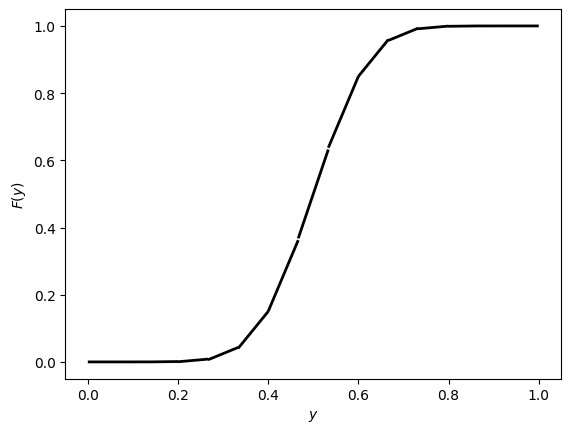

In [8]:
try:
  import matplotlib.pyplot as plt
except:
  warning("Matplotlib not imported")

try:
  fig    = plt.figure()
  Line2D = plot(F)
  plt.xlabel(r'$y$')
  plt.ylabel(r'$F(y)$')

except Exception as e:
  warning("Cannot plot figure. Error msg: '%s'" % e)

try:
  plt.show()
except Exception as e:
  warning("Cannot show figure. Error msg: '%s'" % e)


Having constructed the CDF $F(y)$ we now turn to constructing its PDF $f(y)$ which must remain positive and integrate to one. While strictly speaking the PDF is the derivative of the CDF, we choose to recover the PDF via a projection as this requires less regularlity. To do so define the function space of $f(y)$ to be
\begin{equation*}
    f \in V_f \subset H^1(\Omega_Y), \quad \text{where} \quad f:\Omega_Y \to \mathbb{R}^+ \quad \text{s.t.} \; \left\{ \int f^2 dy < \infty, \int |\nabla f|^2 dy < \infty \right\},
\end{equation*}
thus allowing for weak derivatives followed by a set of basis functions $\{\varphi_i(y)\} \in V_f$ such that
\begin{equation*}
    f(y) = \sum_i f_i \varphi_i(y).
\end{equation*}
We then define the projection in each element $e$ as
\begin{equation*}
    \int_{e} \varphi_e f(y) \; dy = \int_{e} \varphi_e \partial_y F(y) \; dy, \quad \text{where} \quad \forall \varphi_e \in V_{e},
\end{equation*}
which can be integrated by parts in order to put the derivative onto $v$ thus resulting in a boundary flux
\begin{equation*}
    \int_{e} \varphi_e f(y) \; dy = -\int_{e} F(y) \partial_y \varphi_e \; dy + \int_{\partial e} F \varphi_e \cdot \vec{n}_e \; dS, \quad \text{where} \quad \forall \varphi_e \in V_{e},
\end{equation*}
and $\vec{n}_e$ is the outward pointing unit normal. Since $F$ is discontinuous, as evidenced by the previous figure, we have to choose how it is defined at the element facets. To ensure a stable scheme we choose upwinding, which means that must must specify the choice of $F$ at the edges of the domain as well as the interior facets.

Summing the contribution of all the elements $\sum_e \int_e \cdot \; dy = \int_{\Omega_Y} \cdot \; dy$ we obtain
\begin{align}
    \int_{\Omega_Y} v f(y) \; dy = & - \int_{\Omega_Y}        F(y) \partial_y v \; dy \\
                                   & + \int_{\Gamma_{int}}    F_+ v \cdot \vec{n}_e \; dS \\
                                   & + \int_{\Gamma_{max(y)}} F_- v \cdot \vec{n} \; ds \quad \forall v \in V_{f},
\end{align}
where the terms on the left hand side correspond to the cell integral and the integral at right most boundary where we take the interior solution $F_-$. The left most boundary need not be included as for a CDF $F=0$ by definition while the integral over the set of all interior facets $\Gamma_{int}$ vanishes when we upwind.

In [9]:
V_f = FunctionSpace(mesh,"CG",1) # Define a function space consisting of piecewise linear functions

u = TrialFunction(V_f)
v = TestFunction(V_f)

n = FacetNormal(mesh)

# Define the variational forms for the previous equation
a =  inner(u,v) * dx
L = -inner(F,v.dx(0)) * dx  +  F*v*ds(2)


f = Function(V_f)
solve(a == L, f, solver_parameters={'ksp_type':'cg','pc_type':'none'})
File("PDF_Rayleigh_Benard.pvd").write(f)

Finally we visualise the PDF below

<Figure size 640x480 with 0 Axes>

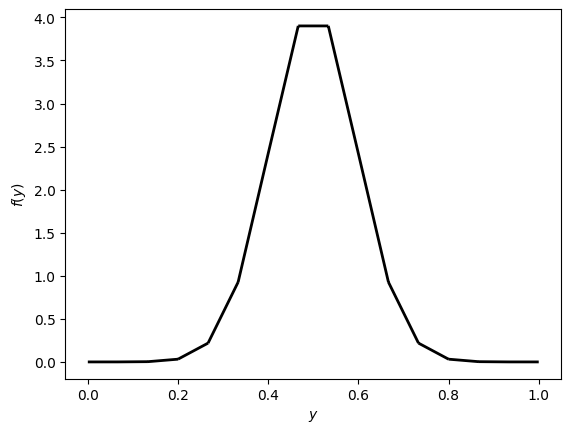

In [10]:
try:
  import matplotlib.pyplot as plt
except:
  warning("Matplotlib not imported")

try:
  fig    = plt.figure()
  Line2D = plot(f)
  plt.xlabel(r'$y$')
  plt.ylabel(r'$f(y)$')

except Exception as e:
  warning("Cannot plot figure. Error msg: '%s'" % e)

try:
  plt.show()
except Exception as e:
  warning("Cannot show figure. Error msg: '%s'" % e)
